# Classification with undersampled data 

In [1]:

import h5py
import warnings

import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import keras.backend as K
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import make_pipeline
import sklearn
from sklearn.utils import class_weight
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, precision_recall_curve
from sklearn.metrics import precision_recall_fscore_support, classification_report, make_scorer
from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import Sequential, load_model
from keras.layers import Dense, LeakyReLU
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [2]:
# read in data

data = pd.read_csv(r"C:\Users\hien\Desktop\masterdata\creditcard.csv")

## Data preprocessing

In [3]:
# Split into training and validation set
x = data.iloc[:,:-1]      # dataframe without class feature
y = data.iloc[:,-1]       # selecting only class feature

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
print ("Training - fraud case: {:.2f}%".format(np.sum(y_train==1)/len(y_train)*100))
print ("Testing - fraud case: {:.2f}%".format(np.sum(y_test==1)/len(y_test)*100))


Training - fraud case: 0.17%
Testing - fraud case: 0.17%


In [4]:
print("# Fraud in training: ", np.sum(y_train==1))
print("# Non-fraud in training: ", np.sum(y_train==0))
print("# Fraud in testing: ", np.sum(y_test==1))
print("# Non-fraud in testing: ", np.sum(y_test==0))

# Fraud in training:  394
# Non-fraud in training:  227451
# Fraud in testing:  98
# Non-fraud in testing:  56864


In [5]:
#scaling time and amount to prevent data leakage

sc_time = RobustScaler()
sc_time.fit(x_train.iloc[:,0:1])
x_train.iloc[:,0:1] = sc_time.transform(x_train.iloc[:,0:1])
x_test.iloc[:,0:1] = sc_time.transform(x_test.iloc[:,0:1])

sc_amount = RobustScaler()
sc_amount.fit(x_train.iloc[:,-1:])
x_train.iloc[:,-1:] = sc_amount.transform(x_train.iloc[:,-1:])
x_test.iloc[:,-1:]= sc_amount.transform(x_test.iloc[:,-1:])

C:\Users\hien\anaconda\envs\new_env\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
C:\Users\hien\anaconda\envs\new_env\lib\site-packages\pandas\core\indexing.py:692: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)
C:\Users\hien\anaconda\envs\new_env\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_

In [6]:
# Split training set into sub-training set for undersampling and validation set to prevent data leakage
x_subtrain, x_val, y_subtrain, y_val = train_test_split(x_train, y_train, test_size=0.2)

In [7]:
from imblearn.under_sampling import NearMiss
from imblearn.under_sampling import CondensedNearestNeighbour
from imblearn.under_sampling import TomekLinks

In [8]:

# Undersampling majority class using random undersampler and training set is used for validation during training

undersamp = RandomUnderSampler(sampling_strategy='majority')
#undersamp = NearMiss(version=1, n_neighbors=3)
#undersamp = CondensedNearestNeighbour(n_neighbors=1)
#undersamp = TomekLinks()

x_subtrain_undersamp, y_subtrain_undersamp = undersamp.fit_resample(x_subtrain, y_subtrain)
print ("Percentage of cases with class 1 for training:{:.4f}".format(np.sum(y_subtrain_undersamp==1)/len(y_subtrain_undersamp)))
print ("Percentage of cases with class 1 for testing:{:.4f}".format(np.sum(y_test==1)/len(y_test)), "\n")

Percentage of cases with class 1 for training:0.5000
Percentage of cases with class 1 for testing:0.0017 



In [9]:
#print ("# Fraud in training: ", np.sum(y_subtrain_undersamp==1))
#print ("# Non-fraud in training: ", np.sum(y_subtrain_undersamp==0))
#print ("# Fraud in testing: ", np.sum(y_test==1))
#print ("# Non-fraud in testing: ", np.sum(y_test==0))

print ("# Fraud in training: ", np.sum(y_subtrain_undersamp==1))
print ("# Non-fraud in training: ", np.sum(y_subtrain_undersamp==0))
print ("# Fraud in validation: ", np.sum(y_val==1))
print ("# Non-fraud in validation: ", np.sum(y_val==0))
print ("# Fraud in test: ", np.sum(y_test==1))
print ("# Non-fraud in test: ", np.sum(y_test==0))

# Fraud in training:  317
# Non-fraud in training:  317
# Fraud in validation:  77
# Non-fraud in validation:  45492
# Fraud in test:  98
# Non-fraud in test:  56864


## Model implementation

In [10]:
from keras.layers import Dropout
from keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv1D, MaxPool1D

In [11]:

       
input_size = x_subtrain_undersamp.shape[1]
epochs = 300
batch_size = 32
save_best_model = "desktop\credit_card_fraud_model_undersamp1.hdf5"




In [118]:

#classifier = Sequential()
#classifier.add(Dense(128, activation="relu", input_shape=(input_size,)))
#classifier.add(BatchNormalization())
#classifier.add(Dropout(0.7))

#classifier.add(Dense(16, activation="relu"))
#classifier.add(BatchNormalization())
#classifier.add(Dropout(0.5))




#classifier.add(Dense(1, activation="sigmoid"))

#classifier.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               3968      
_________________________________________________________________
batch_normalization (BatchNo (None, 128)               512       
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)                2064      
_________________________________________________________________
batch_normalization_1 (Batch (None, 16)                64        
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 1

Epoch 1/300
20/20 [==============================] - 2s 116ms/step - loss: 0.8276 - accuracy: 0.5794 - val_loss: 0.7834 - val_accuracy: 0.5121
Epoch 2/300
20/20 [==============================] - 2s 91ms/step - loss: 0.4952 - accuracy: 0.7619 - val_loss: 0.5518 - val_accuracy: 0.8662
Epoch 3/300
20/20 [==============================] - 2s 93ms/step - loss: 0.4295 - accuracy: 0.8238 - val_loss: 0.4178 - val_accuracy: 0.9451
Epoch 4/300
20/20 [==============================] - 2s 88ms/step - loss: 0.3932 - accuracy: 0.8508 - val_loss: 0.3268 - val_accuracy: 0.9698
Epoch 5/300
20/20 [==============================] - 3s 149ms/step - loss: 0.3657 - accuracy: 0.8508 - val_loss: 0.2666 - val_accuracy: 0.9810
Epoch 6/300
20/20 [==============================] - 2s 107ms/step - loss: 0.3326 - accuracy: 0.8714 - val_loss: 0.2230 - val_accuracy: 0.9851
Epoch 7/300
20/20 [==============================] - 2s 89ms/step - loss: 0.3370 - accuracy: 0.8667 - val_loss: 0.1920 - val_accuracy: 0.9873
Epo

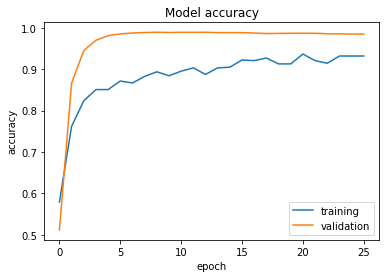

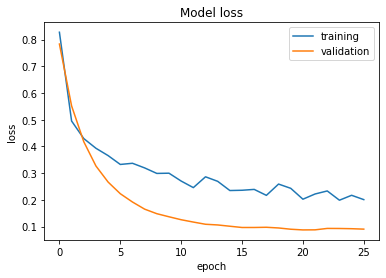

In [119]:
# Note that oversampled training set is split for validation and result in data leakage and overfitting
# Note the high validation accuracy
#classifier.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
#checkpoint = ModelCheckpoint(save_best_model, monitor="val_loss", save_best_only=True, save_weights_only=False)
#earlystop = EarlyStopping(monitor="val_loss", patience=5)
#callbacks_list = [checkpoint, earlystop]
#history = classifier.fit(x_subtrain_undersamp, y_subtrain_undersamp, validation_data=(x_val, y_val), epochs=epochs, batch_size=batch_size, callbacks=callbacks_list, shuffle=True)




# summarize history for accuracy
#plt.plot(history.history['accuracy'])
#plt.plot(history.history['val_accuracy'])
#plt.title('Model accuracy')
#plt.ylabel('accuracy')
#plt.xlabel('epoch')
#plt.legend(['training', 'validation'], loc='lower right')
#plt.show()

# summarize history for loss
#plt.plot(history.history['loss'])
#plt.plot(history.history['val_loss'])
#plt.title('Model loss')
#plt.ylabel('loss')
#plt.xlabel('epoch')
#plt.legend(['training', 'validation'], loc='upper right')
#plt.show()

## Classification results

In [12]:
from sklearn.metrics import average_precision_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import accuracy_score
from sklearn.metrics import auc

In [13]:
classifier = load_model(save_best_model)
y_pred = classifier.predict(x_test)
y_pred = y_pred>=0.5

cm = confusion_matrix(y_test, y_pred)
print ("Confusion matrix:\n", cm)
print ("\n")



print ("accuracy: {:.2f}".format(accuracy_score(y_test, y_pred)))
print ("precision: {:.2f}".format(precision_score(y_test, y_pred)))
print ("recall: {:.2f}".format(recall_score(y_test, y_pred)))
print ("f1 score: {:.2f}".format(f1_score(y_test, y_pred)))
print ("Average precision: {:.2f}".format(average_precision_score(y_test, y_pred)))
print ("AUC-ROC: {:.2f}".format(roc_auc_score(y_test, y_pred)))

precision, recall, _ = precision_recall_curve(y_test, y_pred)


auc_score = auc(recall, precision)
print('Logistic PR AUC: %.3f' % auc_score)

Confusion matrix:
 [[56117   747]
 [   10    88]]


accuracy: 0.99
precision: 0.11
recall: 0.90
f1 score: 0.19
Average precision: 0.09
AUC-ROC: 0.94
Logistic PR AUC: 0.502


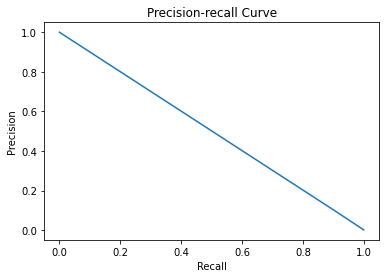

In [14]:
plt.plot(recall, precision)
plt.title("Precision-recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.show()

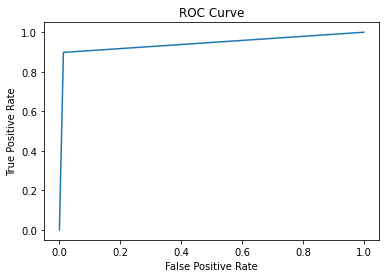

In [15]:
fpr, tpr, _ = roc_curve(y_test, y_pred)
# plot the roc curve for the model

plt.plot(fpr, tpr)
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("ROC Curve")
# show the legend
#plt.legend()
# show the plot
plt.show()



## Feature impact with SHAP

In [16]:
import shap
from ipywidgets import IntProgress

In [20]:

background = shap.kmeans(x_train, 100)
explainer = shap.KernelExplainer(classifier.predict, background)


In [21]:
random_100_x_test = x_test.sample(n=100)

shap_values = explainer.shap_values(random_100_x_test, nsamples=100)

  0%|          | 0/100 [00:00<?, ?it/s]

Text(0.5, 1.0, 'Feature Impact (Undersampled Data)')

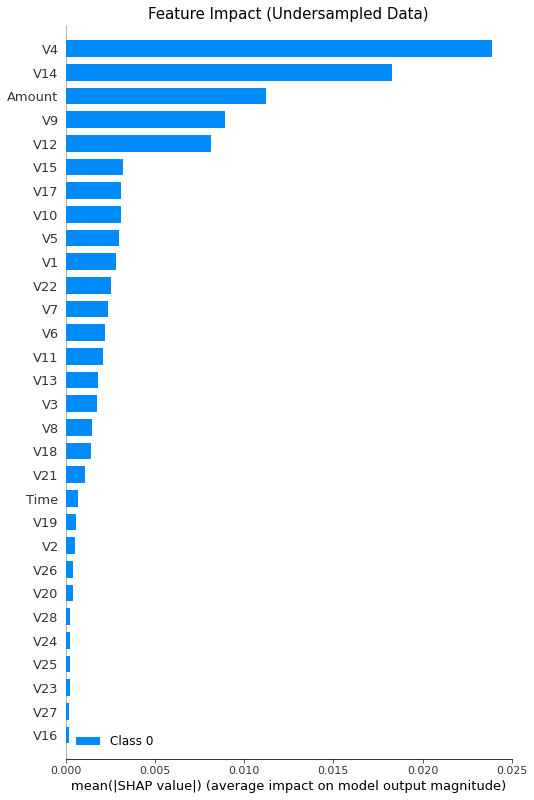

In [25]:
shap.summary_plot(shap_values, x_test, max_display=30, show=False)

# Get the current figure and axes objects.
fig, ax = plt.gcf(), plt.gca()

# Make the modifications that you want. I wanted
# to resize the x-axis, but you can do anything that you'd like.
xlim = 0.025
ax.set_xlim(0, xlim)
ax.set_title("Feature Impact (Undersampled Data)", fontdict={"size":15})

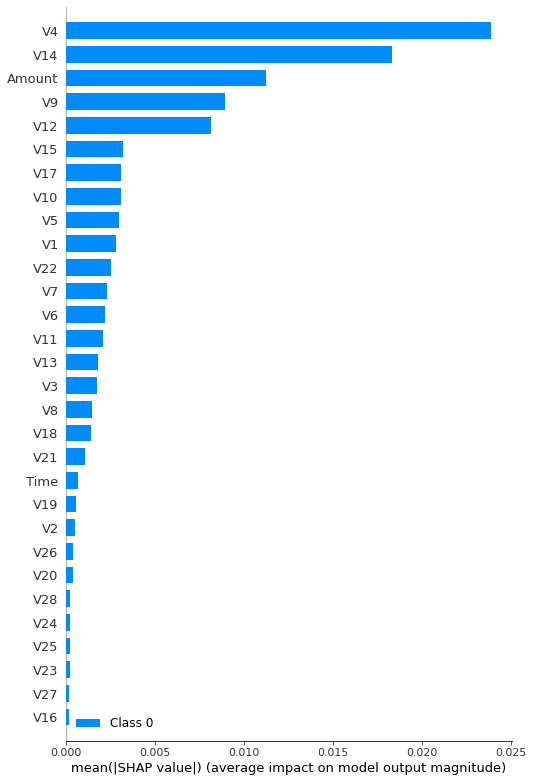

In [23]:
shap.summary_plot(shap_values, x_test, max_display=30)